In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib notebook

In [ ]:
# to bypass warnings in various dataframe assignments
pd.options.mode.chained_assignment = None

In [ ]:
# open our data from google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive

Mounted at /gdrive
/gdrive/MyDrive


In [ ]:
bike_ride_2018 = pd.read_csv('./BA-bikes-rides-2018.csv')

In [ ]:
# put -1 in NaN values
bike_ride_2018 = bike_ride_2018.fillna(-1)
# rename columns and convert id to int 
bike_ride_2018.rename(columns={'fecha_origen_recorrido':'dateTime'}, inplace=True)
bike_ride_2018['id_estacion_origen'] = bike_ride_2018['id_estacion_origen'].astype(int)
bike_ride_2018['id_estacion_destino'] = bike_ride_2018['id_estacion_destino'].astype(int)
bike_ride_2018.head()

,id_usuario,genero_usuario,dateTime,id_estacion_origen,nombre_estacion_origen,long_estacion_origen,lat_estacion_origen,domicilio_estacion_origen,duracion_recorrido,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,long_estacion_destino,lat_estacion_destino,domicilio_estacion_destino
0,5453,M,2018-01-01 00:08:05,45,Uruguay,-58.386913,-34.601616,Tucumán y Uruguay,0 days 00:19:53.000000000,2018-01-01 00:27:58,183,Virrey Cevallos,-58.389692,-34.615638,México 1652 entre Virrey Cevallos y Solís
1,673,M,2018-01-01 00:18:05,189,Posadas,-58.385586,-34.588475,Posadas 1350 entre Montevideo y Rodríguez Peña,0 days 00:26:19.000000000,2018-01-01 00:44:24,110,Guardia Vieja,-58.415459,-34.601761,Guardia Vieja 3606 entre Billinghurst y Mario ...
2,179119,F,2018-01-01 00:20:14,50,Hospital Rivadavia,-58.401148,-34.583677,Lucena Pereyra 2516 entre Las Heras y Pagano,0 days 00:27:39.000000000,2018-01-01 00:47:53,31,Padilla,-58.439709,-34.603162,Padilla y Warnes Av
3,400147,M,2018-01-01 00:20:22,111,Macacha Güemes,-58.363000,-34.604969,Macacha Guemes y Juana Manso,0 days 00:48:51.000000000,2018-01-01 01:09:13,54,Acuña de Figueroa,-58.421705,-34.598222,Lavalle y Acuña de Figueroa
4,400156,F,2018-01-01 00:20:31,111,Macacha Güemes,-58.363000,-34.604969,Macacha Guemes y Juana Manso,0 days 00:49:27.000000000,2018-01-01 01:09:58,54,Acuña de Figueroa,-58.421705,-34.598222,Lavalle y Acuña de Figueroa


In [ ]:
# describe columns
bike_ride_2018.columns

Index(['id_usuario', 'genero_usuario', 'dateTime', 'id_estacion_origen',
       'nombre_estacion_origen', 'long_estacion_origen', 'lat_estacion_origen',
       'domicilio_estacion_origen', 'duracion_recorrido',
       'fecha_destino_recorrido', 'id_estacion_destino',
       'nombre_estacion_destino', 'long_estacion_destino',
       'lat_estacion_destino', 'domicilio_estacion_destino'],
      dtype='object')

In [ ]:
# Get day type - Laboral peak hour or not, weekend (Sat/Sun)
''' param x = datetime type
return dayType = string ['LPH','LNPH','WEND')
 ''' 
from datetime import time
def get_day_type(x):   
  dayWeek = x.dayofweek
  # if laboral day
  if (dayWeek < 5):
    # check if peak hour (Ex: 7 to 9:30 and 17 to 20:30)
    t_7 = time(hour=7, minute=0)
    t_930 = time(hour=9, minute=30)
    t_17 = time(hour=17, minute=0)
    t_2030 = time(hour=20, minute=30)
    if ( t_7 <= x.time() <= t_930) or ( t_17 <= x.time() <= t_2030):
      return 'LPH'
    else:
      return 'LNPH'
  return 'WEND'

In [ ]:
t_7 = time(hour=7, minute=0)
t_930 = time(hour=9, minute=30)
t_17 = time(hour=17, minute=0)
t_2030 = time(hour=20, minute=30)

x = pd.to_datetime(bike_ride_2018.iloc[1170]['dateTime'])
print(x.time())

if (t_7 <= x.time() <= t_930) or ( t_17 <= x.time() <= t_2030):
  print('LPH')

17:22:57
LPH


In [ ]:
# call get_day_type function and save in 'day_type' new column
bike_ride_2018['day_type'] = pd.to_datetime(bike_ride_2018['dateTime']).apply(get_day_type)
bike_ride_2018['day_type']

0          LNPH
1          LNPH
2          LNPH
3          LNPH
4          LNPH
           ... 
2619963    WEND
2619964    WEND
2619965    WEND
2619966    WEND
2619967    WEND
Name: day_type, Length: 2619968, dtype: object

In [ ]:
# get all users in a df
users = bike_ride_2018['id_usuario'].drop_duplicates().reset_index()
users.drop(['index'], axis = 1, inplace=True)
#users.drop(['date'], axis = 1, inplace=True)
users

,id_usuario
0,5453
1,673
2,179119
3,400147
4,400156
...,...
121010,405023
121011,669048
121012,371708
121013,311286


In [ ]:
# calculate total trips for user in weekends
count_trips_user = bike_ride_2018[bike_ride_2018['day_type']=='WEND'].groupby(['id_usuario']).size()
trips_wend = count_trips_user.to_frame(name = 'weekend_trips').reset_index()
trips_wend.describe

<bound method NDFrame.describe of        id_usuario  weekend_trips
0               8              2
1              12              1
2              16              2
3              17              1
4              25              5
...           ...            ...
78595      672025              1
78596      672045              2
78597      672136              1
78598      672155              2
78599      672449              1

[78600 rows x 2 columns]>

In [ ]:
# calculate total trips for user in laboral days Peak hours
count_trips_user = bike_ride_2018[bike_ride_2018['day_type']=='LPH'].groupby(['id_usuario']).size()
trips_lph = count_trips_user.to_frame(name = 'lab_PH_trips').reset_index()
trips_lph.describe

<bound method NDFrame.describe of        id_usuario  lab_PH_trips
0               8             4
1              11             1
2              16             1
3              20             2
4              25            89
...           ...           ...
82701      671444             1
82702      671557             1
82703      671993             2
82704      672043             1
82705      672050             2

[82706 rows x 2 columns]>

In [ ]:
# calculate total trips for user in laboral days Non Peak hours
count_trips_user = bike_ride_2018[bike_ride_2018['day_type']=='LNPH'].groupby(['id_usuario']).size()
trips_lnph = count_trips_user.to_frame(name = 'lab_NPH_trips').reset_index()
trips_lnph.describe

<bound method NDFrame.describe of        id_usuario  lab_NPH_trips
0               8              2
1              17              2
2              20              5
3              21              1
4              24              3
...           ...            ...
97490      671974              3
97491      671979              1
97492      672037              1
97493      672043              2
97494      672050              1

[97495 rows x 2 columns]>

In [ ]:
# merge the 3 dataframes and fill with 0 in NaN values
df = pd.merge(users, trips_wend, how='outer', on='id_usuario')
df = pd.merge(df, trips_lph, how='outer', on='id_usuario')
df = pd.merge(df, trips_lnph, how='outer', on='id_usuario')
df = df.fillna(0)
df

,id_usuario,weekend_trips,lab_PH_trips,lab_NPH_trips
0,5453,14.0,17.0,24.0
1,673,43.0,43.0,49.0
2,179119,0.0,1.0,2.0
3,400147,12.0,8.0,34.0
4,400156,13.0,2.0,46.0
...,...,...,...,...
121010,405023,2.0,0.0,0.0
121011,669048,1.0,0.0,0.0
121012,371708,1.0,0.0,0.0
121013,311286,1.0,0.0,0.0


Text(0.5, 1.0, 'Non Peak hour Laboral Bike rides - Buenos Aires, 2018')

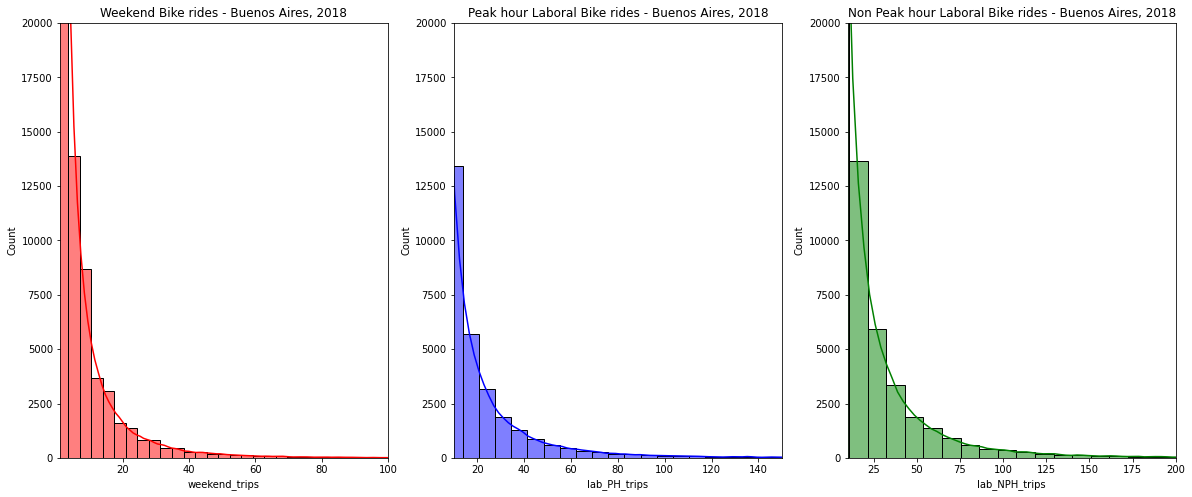

In [ ]:
%matplotlib inline
fig = plt.gcf()
fig.set_size_inches( 20, 8)

plt.subplot(1, 3, 1)
plt.xlim(1, 100)
plt.ylim(0, 20000)
sns.histplot(data=df, x="weekend_trips", bins=60, kde=True, color='red')
ax = plt.gca()
ax.set_title("Weekend Bike rides - Buenos Aires, 2018")

plt.subplot(1, 3, 2)
plt.xlim(10, 150)
plt.ylim(0, 20000)
sns.histplot(data=df, x="lab_PH_trips", bins=60, kde=True, color='blue')
ax = plt.gca()
ax.set_title("Peak hour Laboral Bike rides - Buenos Aires, 2018")

plt.subplot(1, 3, 3)
plt.xlim(10, 200)
plt.ylim(0, 20000)
sns.histplot(data=df, x="lab_NPH_trips", bins=60, kde=True, color='green')
ax = plt.gca()
ax.set_title("Non Peak hour Laboral Bike rides - Buenos Aires, 2018")

In [ ]:
df.iloc[:, 1:]

,weekend_trips,lab_PH_trips,lab_NPH_trips
0,14.0,17.0,24.0
1,43.0,43.0,49.0
2,0.0,1.0,2.0
3,12.0,8.0,34.0
4,13.0,2.0,46.0
...,...,...,...
121010,2.0,0.0,0.0
121011,1.0,0.0,0.0
121012,1.0,0.0,0.0
121013,1.0,0.0,0.0


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
from sklearn.cluster import KMeans
# Find optimal number of clusters
def make_list_of_K(K, dataframe):
    '''inputs: K as integer , dataframe
    apply k-means clustering to dataframe
    and make a list of inertia values against 2 to K (inclusive)
    return the inertia values list
    '''
    
    cluster_values = list(range(2, K+1))
    inertia_values=[]
    
    for c in cluster_values:
        model = KMeans(n_clusters = c)
        model.fit(dataframe)
        inertia_values.append(model.inertia_)
    
    return inertia_values

In [ ]:
# save inertia values for k values between 2 to 15 
results = make_list_of_K(15, df.iloc[:, 1:])

k_values_distances = pd.DataFrame({"clusters": list(range(2, 16)),
                                   "cluster_sum_squared_distances": results})

In [ ]:
k_values_distances

,clusters,cluster_sum_squared_distances
0,2,5.301060e+07
1,3,3.833393e+07
2,4,3.161318e+07
3,5,2.568914e+07
4,6,2.246915e+07
5,7,1.997363e+07
6,8,1.816537e+07
7,9,1.694456e+07
8,10,1.586183e+07
9,11,1.492094e+07


In [ ]:
# visualization for the selection of number of segments
fig = go.Figure()

fig.add_trace(go.Scatter(x=k_values_distances["clusters"], 
                         y=k_values_distances["cluster_sum_squared_distances"],
                         mode='lines+markers'))

fig.update_layout(xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1),
                  title_text="Cluster Sum of Squared Distances VS K Values",
                  xaxis_title="K values",
                  yaxis_title="Cluster sum of squared distances")

fig.show()

In [ ]:
# bike users k means clustering
users_kmeans_model = KMeans(n_clusters = 6)
users_kmeans_model.fit_predict(df.iloc[:,1:])

array([4, 3, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
# add labels to bike users dataframe and add_points array
# create new column with the label (cluster number)
df["clusters"] = users_kmeans_model.labels_
df["cluster_name"] = df["clusters"].astype(str)

In [ ]:
df[df['clusters'] == 4]

,id_usuario,weekend_trips,lab_PH_trips,lab_NPH_trips,clusters
0,5453,14.0,17.0,24.0,4
3,400147,12.0,8.0,34.0,4
13,282498,9.0,5.0,25.0,4
14,158706,8.0,7.0,40.0,4
18,278973,10.0,2.0,37.0,4
...,...,...,...,...,...
119179,662771,7.0,4.0,23.0,4
119206,614051,10.0,2.0,17.0,4
119256,262597,13.0,16.0,3.0,4
119572,664644,7.0,1.0,15.0,4


In [ ]:
# visualize bike users clusters with a 3D plot
import plotly.express as px
fig = px.scatter_3d(df,
                    x="weekend_trips",
                    y="lab_PH_trips", 
                    z="lab_NPH_trips",                   
                    color="cluster_name",                                      
                    category_orders = {"cluster_name": 
                                       ["0", "1", "2", "3", "4", "5"]},                    
                    )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
# Check for cluster magnitude
# values for log_transformation
cardinality_df = pd.DataFrame(
    df.cluster_name.value_counts().reset_index())

cardinality_df.rename(columns={"index": "User_Groups",
                               "cluster_name": "User_Group_Magnitude"},
                      inplace=True)


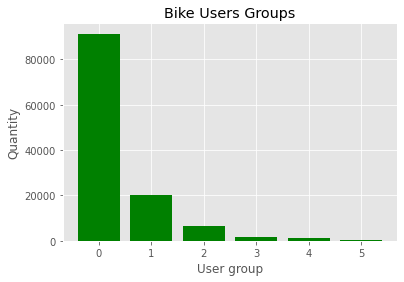

In [ ]:
# Bar graph with quantity of bike users on each group
plt.style.use('ggplot')

x = ["0", "1", "2", "3", "4", "5"]
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, cardinality_df.User_Group_Magnitude, color='green')
plt.xlabel("User group")
plt.ylabel("Quantity")
plt.title("Bike Users Groups")

plt.xticks(x_pos, x)

plt.show()